In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import h2o
from h2o.automl import H2OAutoML

In [2]:
df_train = pd.read_csv('train.csv')
df_weather_train = pd.read_csv('weather_train.csv')
df_building_metadata = pd.read_csv('building_metadata.csv')

In [3]:
train_copy = df_train.copy()
weather_copy = df_weather_train.copy()
building_copy = df_building_metadata.copy()

In [4]:
df_train.head(5)

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [5]:
df_train.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading'], dtype='object')

In [6]:
df_weather_train.sample(5)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
118656,13,2016-07-23 01:00:00,31.7,NaN,17.2,0.0,1013.4,160.0,3.6
23994,2,2016-09-25 15:00:00,22.2,0.0,5.0,0.0,1014.4,210.0,1.5
4344,0,2016-06-30 00:00:00,26.7,8.0,23.9,0.0,1015.3,180.0,3.1
137953,15,2016-10-15 22:00:00,16.1,0.0,5.6,NaN,1024.0,170.0,3.6
105135,12,2016-01-06 11:00:00,5.2,6.0,3.7,NaN,995.4,250.0,2.0


In [8]:
zero_meter = df_train[df_train.meter_reading==0].groupby('building_id').agg({'meter_reading':'count'})

In [9]:
zero_meter.count()

meter_reading    959
dtype: int64

In [10]:
df_building_metadata.count()

site_id        1449
building_id    1449
primary_use    1449
square_feet    1449
year_built      675
floor_count     355
dtype: int64

In [ ]:
#  66.18% of the total building has zero meter_reading

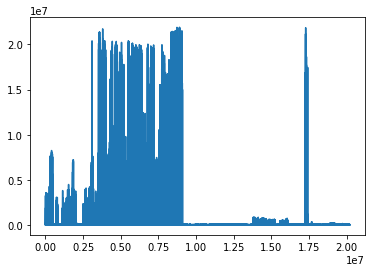

In [11]:
plt.plot(df_train['meter_reading'])

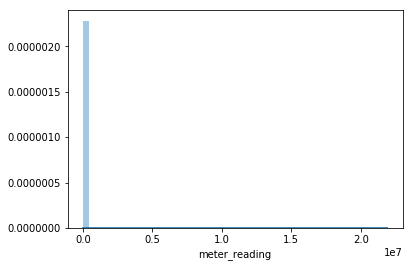

In [12]:
sns.distplot(df_train['meter_reading'])

In [13]:
# the max meter_reading:
df_train[df_train.meter_reading > 100000].count()

building_id      5482
meter            5482
timestamp        5482
meter_reading    5482
dtype: int64

In [14]:
df_train['meter_reading'].mean()
# most meter_reading are below 1,000,000, with mean 2117

2117.1210762169394

## Most of the high-meter-reading data are concentrated in 8 building, others can be regarded as outliers

In [15]:
temp = df_train[df_train.meter_reading > 10000][['building_id']].groupby('building_id').agg({'building_id':'count'})
temp.columns = {'amount'}
temp.reset_index()
temp.sort_values(by = 'amount', ascending=False)

,amount
building_id,
1159,8773
1168,8726
1148,8322
1197,8060
1284,6886
1214,5340
1156,4759
1088,4673
1289,4137


In [16]:
temp = df_train.groupby('building_id').agg({'meter':'unique'}).reset_index()

In [19]:
temp['meter'] = temp['meter'].astype('str')
temp.groupby('meter').agg({'meter':'count'})
# Not all the building have all type of meters, and meter 0 is most common.

,meter
meter,
[0 1 2 3],13
[0 1 2],210
[0 1 3],108
[0 1],132
[0 2 1],9
[0 2],63
[0 3 1],1
[0 3],20
[0],852


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

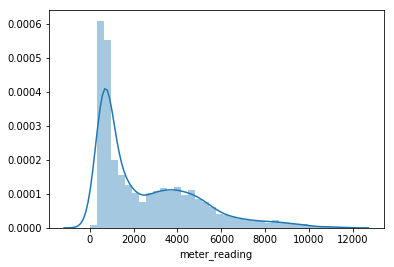

In [20]:
sns.distplot(df_train[(df_train.building_id == 1108) & (df_train.meter == 2)]['meter_reading'])

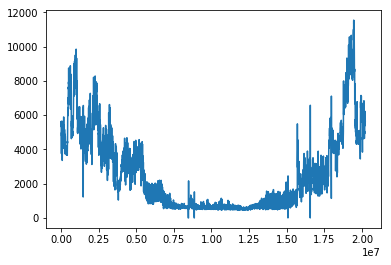

In [21]:
plt.plot(df_train[(df_train.building_id == 1108) & (df_train.meter == 2)]['meter_reading'])

## Remove the outliers using up/bottom 0.1%

In [22]:
def f1(x):
    return x.quantile(0.005)
def f2(x):
    return x.quantile(0.995)
filter1 = df_train.groupby('building_id').agg({'meter_reading':[f1,f2]}).reset_index()
filter1.columns = filter1.columns.droplevel()

In [23]:
filter1.columns = ['building','f1','f2']

In [24]:
filter1.head()

,building,f1,f2
0,0,0.0,321.486000
1,1,0.0,163.837290
2,2,0.0,60.646116
3,3,0.0,610.920070
4,4,0.0,1872.950000


In [25]:
merge = pd.merge(train_copy, filter1, how='left',left_on='building_id', right_on='building')

In [26]:
merge['meter_alter'] = merge['meter_reading']
merge.loc[merge.meter_reading < merge.f1, 'meter_alter'] = merge.f1
merge.loc[merge.meter_reading > merge.f2, 'meter_alter'] = merge.f2

In [27]:
merge_final = merge.drop(columns=['building','f1','f2','meter_reading'])

In [28]:
merge_final.sample(5)

,building_id,meter,timestamp,meter_alter
925137,404,0,2016-01-17 19:00:00,158.280
5851592,1220,2,2016-04-20 01:00:00,1867.190
13658326,627,0,2016-09-06 07:00:00,108.750
15416943,235,0,2016-10-07 10:00:00,49.470
12771040,1306,1,2016-08-21 10:00:00,763.436


In [ ]:
merge_final.to_csv('merge.csv')